# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [30]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0 - full 2018 adel with zone groups"

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [7]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [8]:
fecha_limit = "2018-01-01"
df = df[df["FECHA_SINI"] >= fecha_limit]

In [9]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [10]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[df["EXISTE_INVEST"] < 7]
df_val = df_val[df_val["EXISTE_INVEST"] < 7]

In [11]:
df["TIPO_EXPED"].value_counts()

2    225278
3    203555
1     40735
6     32020
4      6571
5      5556
0      2750
Name: TIPO_EXPED, dtype: int64

In [12]:
df["EXISTE_FRAUDE"].value_counts()

False    514483
True       1982
Name: EXISTE_FRAUDE, dtype: int64

In [13]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [14]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [15]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [16]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [20]:
# using only last year
split_date = "2018-10-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-01 00:00:00 2018-09-30 00:00:00
2018-10-01 00:00:00 2019-01-31 00:00:00


In [21]:
df_opt["EXISTE_FRAUDE"].value_counts()

False    155292
True        710
Name: EXISTE_FRAUDE, dtype: int64

In [22]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.69794274539417, 0.30205725460583)

In [23]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [24]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"] # , "es_gte_5"

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [25]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [26]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [27]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

360463, 156002
360463, 156002


In [28]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.0035287949109894775, 0.0045512237022602275)

In [29]:
y_train.value_counts(dropna=False)

False    359191
True       1272
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [32]:
from sklearn.utils.class_weight import compute_class_weight

In [33]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights, weights[1] / weights[0]

(array([  0.50192621, 130.28884965]), 259.5776992936428)

In [34]:
# configs
list_weights = [30, 35]
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 30}, {0: 1, 1: 35}]

In [37]:
rf_params = {
    "n_estimators": [100],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
# param_configs.append(rf_params)
# param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


n_estimators = [60, 100]

gbt_params = {
    'n_estimators': n_estimators, 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': n_estimators, 
#    'num_leaves': [10, 20, 50],
#    'max_depth': [5, 10, 30],
#    'min_child_samples': [3, 5, 7],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bytree": [0.5 , 1],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'scale_pos_weight': [30, 35]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'class_weight': [{0: 1, 1: 30}, {0: 1, 1: 35}]}]

In [38]:
# using without grid with list of models
rfs = []
# rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
# rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
rfs.append(XGBClassifier(random_state=random_state))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='binary:logistic',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=True, subsample=1),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]

In [39]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=1)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 12 parameter setting(s) using 1 CPU thread(s) ( 12 job(s) per thread ).
Best score: 0.7887323943661971
Best config: {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 35}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=N

In [40]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.01, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=35,
                               seed=0, silent=True, subsample=1),
           num_threads=1,
           param_grid={'learning_rate': [1.0, 0.1, 0.01],
                       'n_estimators': [60, 100],
                       'scale_pos_weight': [30, 35]},
           seed=42) 0.7887323943661971
GridSearch(cv_folds=3,
           model=LGBMClassifier(boosting_type='gbdt',
                                class_weight={0: 1, 1: 35},
              

In [41]:
# select best grid
best_model = best_models_[np.argmax(best_scores_)]

# select by hand
# best_model = best_models_[1]

In [42]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
0.708 for {'class_weight': {0: 1, 1: 35}, 'learning_rate': 0.1, 'n_estimators': 60}
0.676 for {'class_weight': {0: 1, 1: 30}, 'learning_rate': 0.1, 'n_estimators': 60}
0.668 for {'class_weight': {0: 1, 1: 30}, 'learning_rate': 1.0, 'n_estimators': 60}
0.666 for {'class_weight': {0: 1, 1: 35}, 'learning_rate': 1.0, 'n_estimators': 60}
0.654 for {'class_weight': {0: 1, 1: 30}, 'learning_rate': 1.0, 'n_estimators': 100}
0.618 for {'class_weight': {0: 1, 1: 35}, 'learning_rate': 0.01, 'n_estimators': 100}
0.607 for {'class_weight': {0: 1, 1: 30}, 'learning_rate': 0.01, 'n_estimators': 100}
0.539 for {'class_weight': {0: 1, 1: 35}, 'learning_rate': 1.0, 'n_estimators': 100}
0.539 for {'class_weight': {0: 1, 1: 35}, 'learning_rate': 0.1, 'n_estimators': 100}
0.503 for {'class_weight': {0: 1, 1: 30}, 'learning_rate': 0.1, 'n_estimators': 100}
0.000 for {'class_weight': {0: 1, 1: 30}, 'learning_rate': 0.01, 'n_estimators': 60}
0.000 for {'class_weight': {0: 1, 1: 35}, 'learning_ra

In [43]:
best_model.best_estimator_.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 35},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [44]:
y_val_pred = best_model.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.2953197099538563, 0.8544164851192798)

In [45]:
confusion_matrix(y_val, y_val_pred)

array([[70520,   983],
       [   86,   224]])

**old**

Best model:
ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 2},
           criterion='gini', max_depth=30, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=7,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [44]:
y_val_pred = best_model.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.7479224376731303, 0.6650300860127727)

In [45]:
confusion_matrix(y_val, y_val_pred)

array([[120, 143],
       [ 39, 270]])

**Tronador**

In [46]:
y_val_tron = X_val["total_condicion"] >= 5
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI = f1_score(y_val, y_val_tron), roc_auc_score(y_val, y_val_tron)
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI

(0.3472949389179756, 0.8165133833771018)

In [47]:
confusion_matrix(y_val, y_val_tron)

array([[70866,   637],
       [  111,   199]])

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

In [48]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
65,CODIGO_VEHICULO,73
93,dias_entre_denu_y_sini,69
103,COD_PROD,65
67,COD_POST_OCURRENCIA,65
66,COD_CAUSA_SINI,51
94,dist_fformal_fsini,51
88,TIPO_EXPED,51
68,COD_POST_POLIZA,48
117,ANTIG_pol,44
89,TIPO_LESION,43


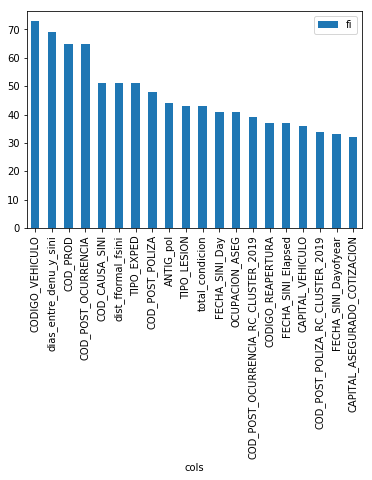

In [49]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [52]:
to_keep = list(rf_fi[rf_fi["fi"] >=10]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 54 of 152


In [50]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

In [55]:
# best model
clf.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 35},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [53]:
X_train_red = X_train[to_keep].copy()

In [54]:
print(len(X_train_red.columns))

54


### Training again with less features

In [56]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 35},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [57]:
y_opt_pred = rf.predict(X_opt[to_keep])
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_val_pred), roc_auc_score(y_opt, y_val_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.3162970106075217, 0.840332387908576)

In [58]:
confusion_matrix(y_opt, y_opt_pred)

array([[153383,   1909],
       [   218,    492]])

In [59]:
rf_fi_red = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi_red[:10]

,cols,fi
3,COD_POST_OCURRENCIA,92
0,CODIGO_VEHICULO,77
1,dias_entre_denu_y_sini,75
2,COD_PROD,72
4,COD_CAUSA_SINI,68
15,FECHA_SINI_Elapsed,66
5,dist_fformal_fsini,64
11,FECHA_SINI_Day,64
16,CAPITAL_VEHICULO,63
6,TIPO_EXPED,62


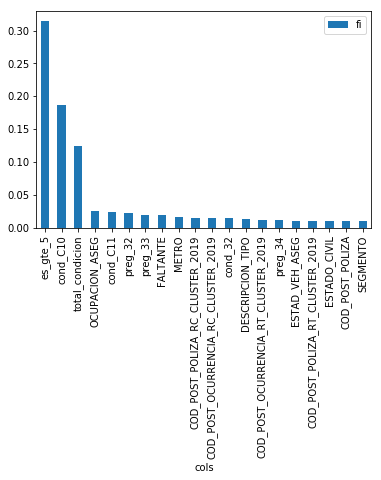

In [62]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [60]:
rf_full = copy(best_model.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 35},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [61]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.295, 0.978


In [62]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[70520,   983],
       [   86,   224]])

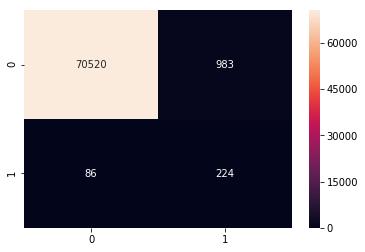

In [63]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [67]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 35},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [68]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.316, 0.980


In [69]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[70602,   901],
       [   83,   227]])

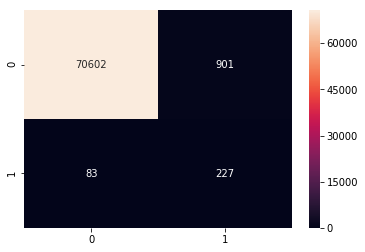

In [70]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [64]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3472949389179756,0.8165133833771018)


In [65]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[70866,   637],
       [  111,   199]])

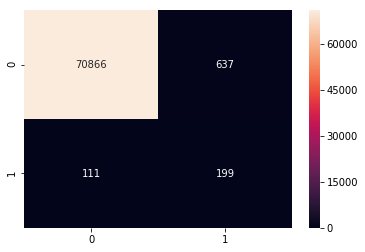

In [66]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [71]:
path_to_save = f"models/{model_id}/"
os.makedirs(path_to_save, exist_ok=True)

In [72]:
model_file = os.path.join(path_to_save, f"{model_id}.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

In [73]:
# save file for humans
model_file = os.path.join(path_to_save, f"{model_id} - readable.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, 0) # 0 is human readable format

In [74]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['CODIGO_VEHICULO', 'dias_entre_denu_y_sini', 'COD_PROD', 'COD_POST_OCURRENCIA', 'COD_CAUSA_SINI', 'dist_fformal_fsini', 'TIPO_EXPED', 'COD_POST_POLIZA', 'ANTIG_pol', 'TIPO_LESION', 'total_condicion', 'FECHA_SINI_Day', 'OCUPACION_ASEG', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'CODIGO_REAPERTURA', 'FECHA_SINI_Elapsed', 'CAPITAL_VEHICULO', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'FECHA_SINI_Dayofyear', 'CAPITAL_ASEGURADO_COTIZACION', 'cond_C15', 'CANT_RENOVACION', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'ESTADO_CIVIL', 'cond_C13', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'SEGMENTO', 'CODIGO_CARATULA', 'dist_fformal_fdenu', 'TELEFONO_TERC', 'FALTANTE', 'TIPO_SINIESTRO', 'CAPITAL_ACCESORIOS', 'preg_34', 'CONDICION_ROBO_EXP50', 'DANOS_MATERIALES', 'cond_C1', 'COD_POST_TERC', 'cond_C10', 'FECHA_SINI_Dayofweek', 'SEXO', 'COD_POST_TERC_DP_CLUSTER_2019', 'MCA_JUICIO', 'cond_12', 'NEGOCIO', 'preg_33', 'cond_C6', 'CIF_ID', 'preg_32', 'COD_POST_TERC_RC_CLUSTER_2019', 'DESCRIPCION_TIPO', 'preg_9', 'COD_ZONA_RC'

In [75]:
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - n_features_{len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [81]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [76]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [77]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [79]:
m = load_model(model_file)
columns = load_columns(columns_file)
print(len(columns))

54


In [80]:
X_test = df_test[X_train.columns]
y_test = df_test["EXISTE_FRAUDE"]

In [81]:
X_test.head()

,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,total_condicion,es_gte_5,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RAMO_sini,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed,cant_pol,cant_sini_1y,COD_POST_POLIZA_DP_CLUSTER_2019,COD_POST_POLIZA_RT_CLUSTER_2019,COD_POST_POLIZA_RC_CLUSTER_2019,COD_POST_OCURRENCIA_DP_CLUSTER_2019,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_OCURRENCIA_RC_CLUSTER_2019,COD_POST_TERC_DP_CLUSTER_2019,COD_POST_TERC_RT_CLUSTER_2019,COD_POST_TERC_RC_CLUSTER_2019
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,18380.0,226.0,1439.0,1439.0,-1.0,1.0,1.0,-1.0,0,3,0,-1,5.0,1,0,-1,1,1,44.0,1,-1,-1,3.0,3,-1,-1,5,1.0,0.0,-1.0,-1.0,0,24.0,8,2293,4514,0,0,73747.0,1.0,1.0,3.0,23,-1.0,0,0,-1,1,21,0,5,0,699.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,28.0,8.0,26.0,28.0,8.0,26.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,6846.0,226.0,1708.0,1684.0,-1.0,1.0,1.0,-1.0,0,3,0,-1,3.0,1,0,-1,1,1,5.0,1,-1,-1,3.0,3,-1,-1,5,1.0,0.0,-1.0,-1.0,0,41.0,8,1985,3913,0,0,5350.0,1.0,1.0,1.0,107,-1.0,0,0,-1,1,21,0,4,0,1216.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,25.0,8.0,26.0,25.0,8.0,26.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,4.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4,-1,0,-1,-1,-1,-1,121,133,1,-1,1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,2605.0,202.0,1678.0,1407.0,-1.0,1.0,1.0,1.0,0,3,6,-1,3.0,1,0,-1,0,1,44.0,1,-1,-1,3.0,5,-1,-1,6,1.0,0.0,-1.0,-1.0,0,1.0,8,433,674,5,-1,73761.0,1.0,1.0,3.0,38,-1.0,0,0,0,0,43,0,4,0,0.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800,0.0,0.0,25.0,5.0,22.0,27.0,6.0,24.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,

## Model in test

In [82]:
# using trained model
y_test_pred_prob = best_model.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.244, 0.989


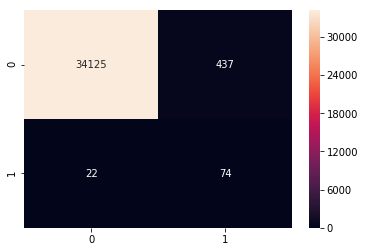

In [83]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [84]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.330, 0.851


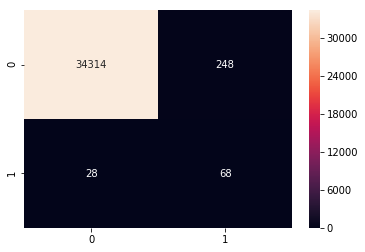

In [85]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Evaluate result by tipo_exped

In [87]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], y_test_pred_prob > 0.5])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                163     0     0     0
1               2603     0     0     0
2              16091     3     0     0
3              12422   103     1     0
4                430     3     0     0
5                336    36     6     4
6               2080   292    15    70